In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

from data.util import *
from descriptiveAnalytics.utils import *

In [3]:
dow_johnes = load_data_from_folder(DATA_FOLDERS[0])
ftse_100 = load_data_from_folder(DATA_FOLDERS[1])
nikkei_225 = load_data_from_folder(DATA_FOLDERS[2])
sp_500 = load_data_from_folder(DATA_FOLDERS[3])
EGX_30 = load_data_from_folder(DATA_FOLDERS[4])

dfs = {
    Indices.dow_Jones.name  : dow_johnes,
    Indices.ftse_100.name   : ftse_100,
    Indices.nikkei_225.name : nikkei_225,
    Indices.sp_500.name     : sp_500,
    Indices.EGX_30.name     : EGX_30}

In [4]:
colNames = []
for index in Indices:
    for col in ColumnNames:
        if "Date" not in col.name:
            colNames.append(f"{index.name}_{col.name}")
indices = []
for index in Indices:
    indices.append(index.name)
            
for df in dfs:
    dfs[df] = cast_columns_to_double(dfs[df])
    dfs[df] = rename_columns(dfs[df], df)
    print(f"{df}: ")
    print(f"{dfs[df]}")
    dfs[df].describe().show()

dow_Jones: 
DataFrame[Date: string, dow_Jones_Close: double, dow_Jones_High: double, dow_Jones_Low: double, dow_Jones_Open: double, dow_Jones_Volume: double]
+-------+----------+------------------+-----------------+------------------+------------------+--------------------+
|summary|      Date|   dow_Jones_Close|   dow_Jones_High|     dow_Jones_Low|    dow_Jones_Open|    dow_Jones_Volume|
+-------+----------+------------------+-----------------+------------------+------------------+--------------------+
|  count|      3522|              3522|             3522|              3522|              3522|                3522|
|   mean|      NULL|21712.507973596767|21825.74421354832|21584.509138983532|21707.796203439986| 2.384138358886996E8|
| stddev|      NULL| 8037.528384265559|8081.914849522401| 7991.416107733758| 8037.466348928835|1.3382979847076967E8|
|    min|2010-01-04|     9686.48046875|  9770.8701171875|      9614.3203125|     9686.48046875|           8410000.0|
|    max|2023-12-29|   

In [5]:
# merged_df_outer_join = EGX_30.join(sp_500, "Date", "outer") \
#                      .join(ftse_100, "Date", "outer") \
#                      .join(nikkei_225, "Date", "outer") \
#                      .join(dow_johnes, "Date", "outer") 

# merged_df_outer_join.count()
# merged_df_outer_join = cast_columns_to_double(merged_df_outer_join)

In [6]:
merged_df_inner_join = dfs[Indices.EGX_30.name].join(dfs[Indices.sp_500.name], "Date", "inner") \
                     .join(dfs[Indices.ftse_100.name], "Date", "inner") \
                     .join(dfs[Indices.nikkei_225.name], "Date", "inner") \
                     .join(dfs[Indices.dow_Jones.name], "Date", "inner")
merged_df_inner_join = cast_columns_to_double(merged_df_inner_join)
merged_df_inner_join = merged_df_inner_join.dropna()

In [7]:
from pyspark.sql.window import Window  # Import Window for defining window specifications
from pyspark.sql.functions import lag, col, when

# Define a window specification
window_spec = Window.partitionBy().orderBy("Date")

daily_return_dfs = []
daily_return_df = merged_df_inner_join

for df in dfs:
    col_name = f"{df}_{ColumnNames.Close.name}"
    daily_return_dfs.append(f"{df}_daily_return")
    daily_return_df = daily_return_df.withColumn(
        f"{df}_daily_return",
        when(
        lag(col_name, 1).over(window_spec).isNotNull(),
        (col(col_name) - lag(col_name, 1).over(window_spec)) / lag(col_name, 1).over(window_spec)
        ).otherwise(0)
    )

daily_return_df = daily_return_df.select(["Date"] + daily_return_dfs)
    # daily_return_dfs.append(dfs[df].withColumn(
    #     f"{df}_daily_return",
    #     when(
    #     lag(col_name, 1).over(window_spec).isNotNull(),
    #     (col(col_name) - lag(col_name, 1).over(window_spec)) / lag(col_name, 1).over(window_spec)
    #     ).otherwise(0)
    # ))

# for df in daily_return_dfs:
#     df.show()

daily_return_df.describe().show()
daily_return_df.show()
daily_return_df = daily_return_df.toPandas()

+-------+----------+----------------------+---------------------+-----------------------+--------------------+--------------------+
|summary|      Date|dow_Jones_daily_return|ftse_100_daily_return|nikkei_225_daily_return| sp_500_daily_return| EGX_30_daily_return|
+-------+----------+----------------------+---------------------+-----------------------+--------------------+--------------------+
|  count|      2836|                  2836|                 2836|                   2836|                2836|                2836|
|   mean|      NULL|  5.191879687659587E-4| 1.819534268810763...|   5.053858852278603E-4|5.788227024205645E-4|6.146590222596735E-4|
| stddev|      NULL|   0.01187299425876439|  0.01112017822674024|   0.014182108548995445|0.011858730470301684| 0.01635592096124115|
|    min|2010-01-04|  -0.14285524745363495| -0.12344080700140389|   -0.12433116792909543| -0.1295880232532872|-0.15768814341815168|
|    max|2023-12-28|    0.1136504119941154|  0.09053046847095778|    0.08038

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


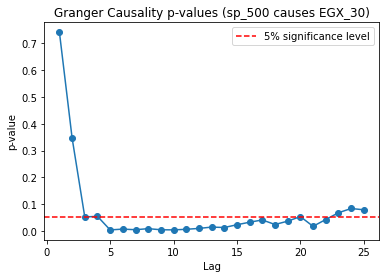

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


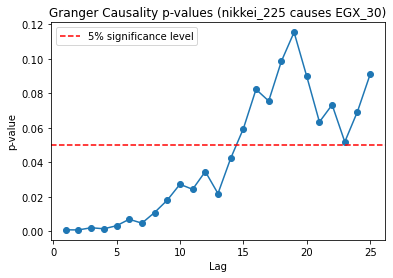

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


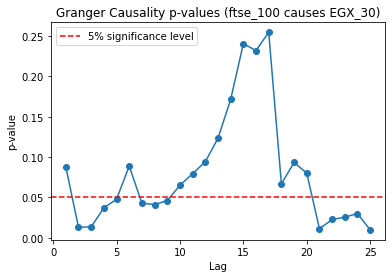

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


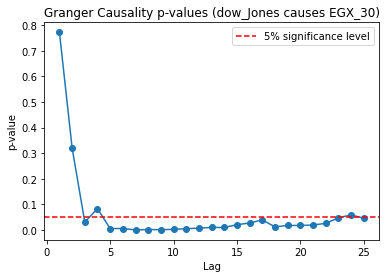

In [8]:
max_lag = 25

for index in indices:
    if "EGX" in index:
        continue
        
    gc_test_result = grangercausalitytests(daily_return_df[[f'{index}_daily_return', f'{Indices.EGX_30.name}_daily_return']], max_lag,verbose=False)

    lags = list(range(1, max_lag + 1))
    p_values = [gc_test_result[lag][0]['ssr_chi2test'][1] for lag in range(1, max_lag + 1)]
    
    plt.plot(lags, p_values, marker='o')
    plt.axhline(y=0.05, color='r', linestyle='--', label="5% significance level")
    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.title(f"Granger Causality p-values ({index} causes EGX_30)")
    plt.legend()
    plt.show()


In [9]:
corr_mat = np.zeros((len(dfs), len(dfs)))
for x, xdf in enumerate(dfs):
    for y, ydf in enumerate(dfs):
        corr_mat[x,y] = merged_df_inner_join.stat.corr(f"{xdf}_{ColumnNames.Close.name}", f"{ydf}_{ColumnNames.Close.name}")

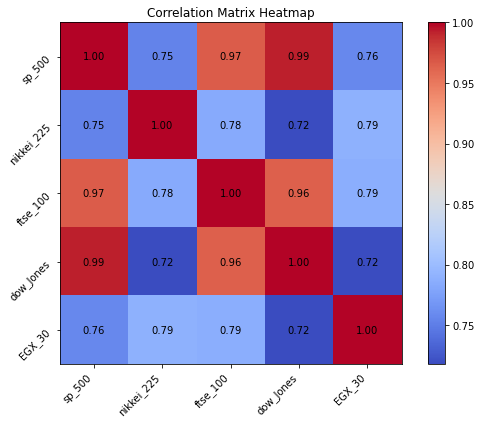

In [10]:
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(corr_mat, cmap="coolwarm", interpolation="nearest")

plt.colorbar(heatmap)

plt.xticks(ticks=np.arange(len(indices)), labels=indices, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(indices)), labels=indices, rotation=45)

# Add annotations
for i in range(len(indices)):
    for j in range(len(indices)):
        plt.text(j, i, f"{corr_mat[i, j]:.2f}", ha="center", va="center", color="black")

# Title and layout
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [11]:
for col in colNames:
    summary = calculate_summary_stats(merged_df_inner_join,[col])
    summary.show()

+------------------+------------------+------------------+---------------+--------------------+
|  sp_500_Open_mean|sp_500_Open_stddev|   sp_500_Open_min|sp_500_Open_max|sp_500_Open_skewness|
+------------------+------------------+------------------+---------------+--------------------+
|2520.6860055425777| 1057.964209232941|1028.0899658203125| 4804.509765625|  0.5152976703738176|
+------------------+------------------+------------------+---------------+--------------------+

+------------------+-------------------+----------------+----------------+---------------------+
| sp_500_Close_mean|sp_500_Close_stddev|sp_500_Close_min|sp_500_Close_max|sp_500_Close_skewness|
+------------------+-------------------+----------------+----------------+---------------------+
|2520.9199361222754| 1057.9851392150438|1028.06005859375| 4793.5400390625|   0.5160010776062546|
+------------------+-------------------+----------------+----------------+---------------------+

+------------------+-------------

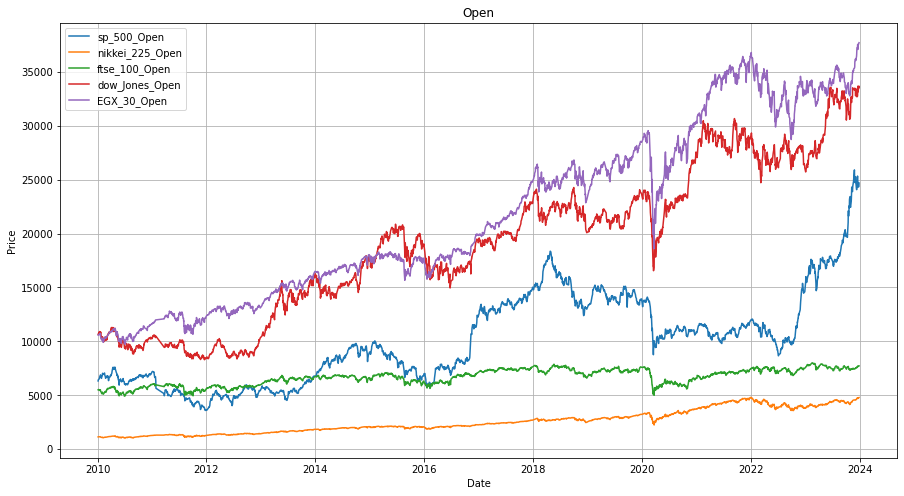

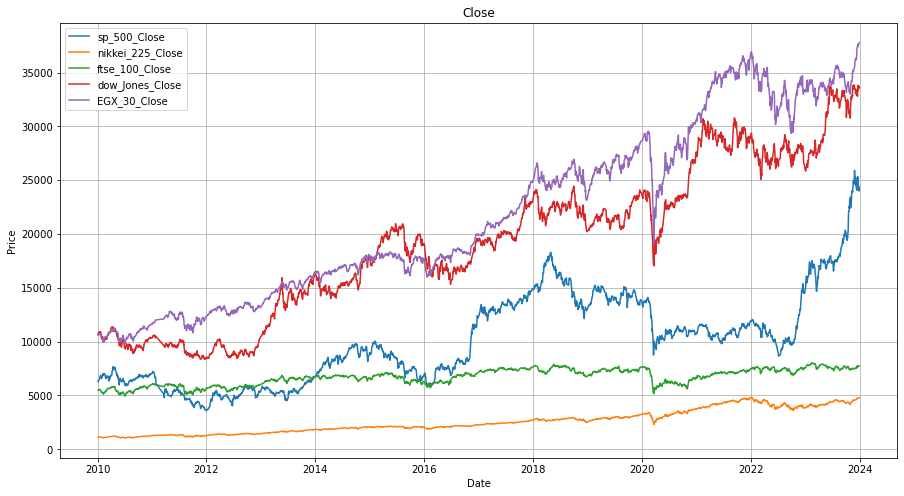

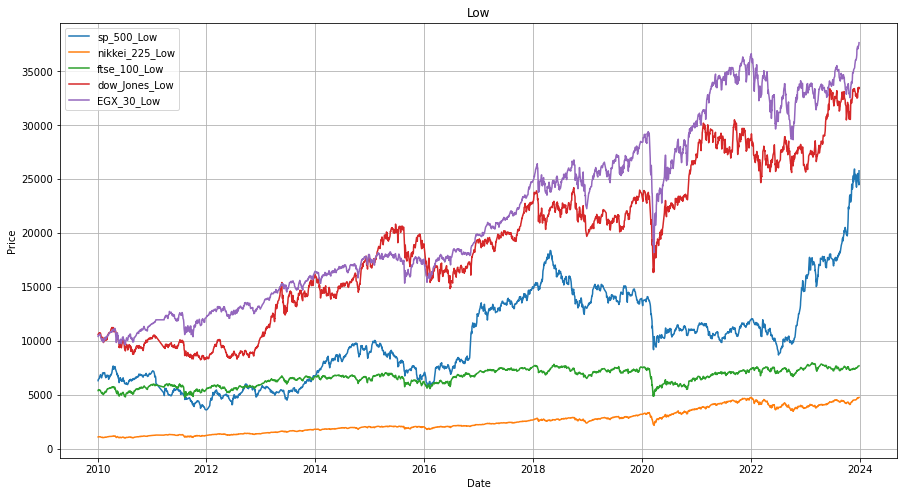

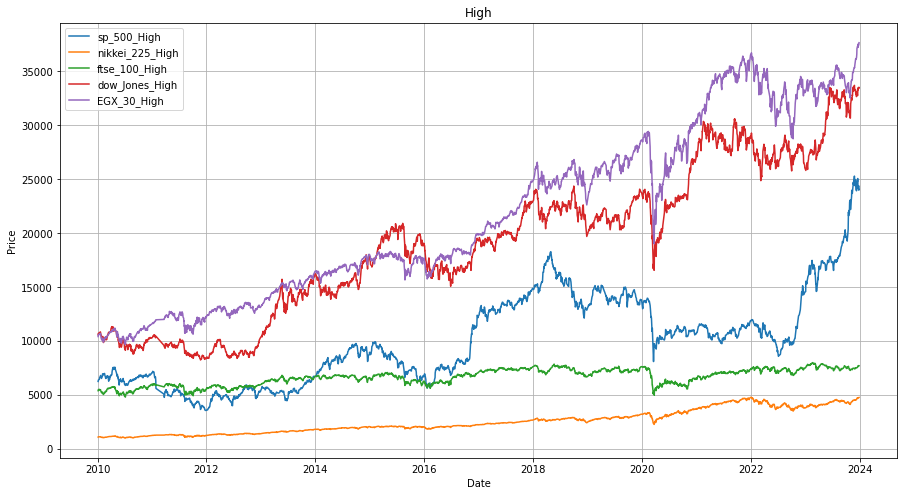

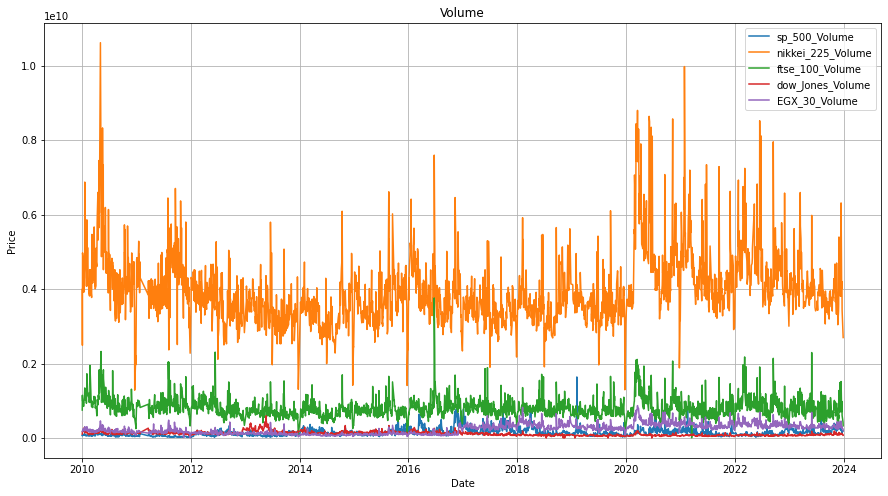

In [12]:
pdf = merged_df_inner_join.select(["Date"] + merged_df_inner_join.columns[1:]).orderBy("Date").toPandas().to_numpy()

for i in range(5):
    plot_numpy_array(
        data= pdf,
        column_names=["Date"] + colNames,
        date_col="Date",
        price_cols=colNames[i::5],
        title=colNames[i::5][0].split("_")[-1]
    )

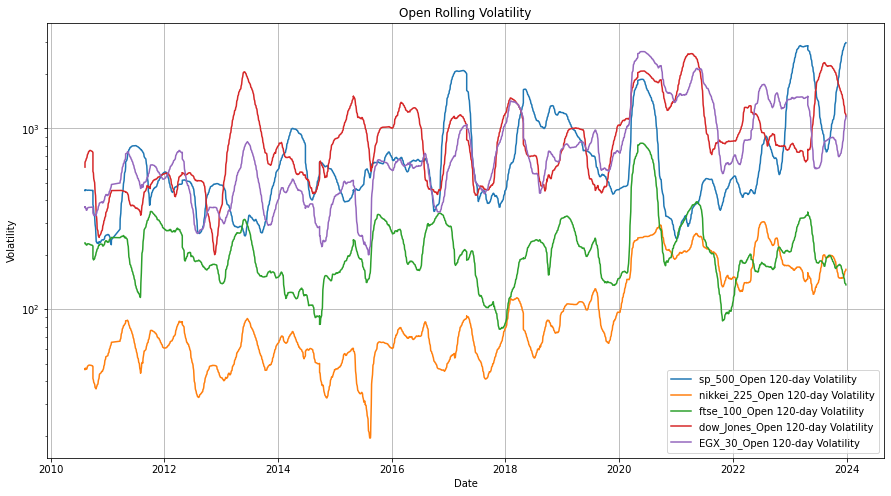

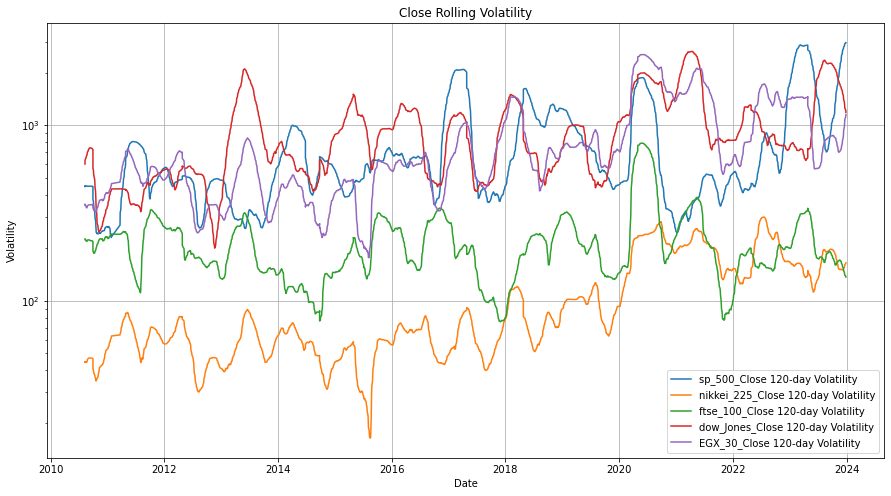

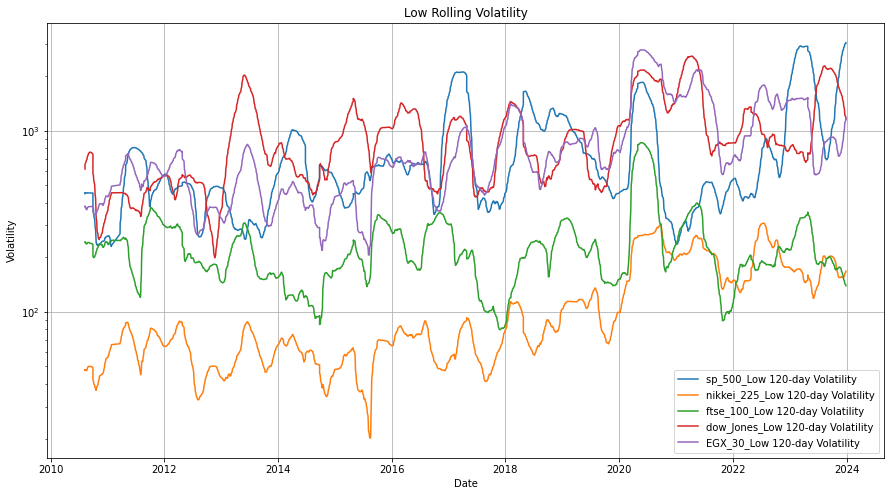

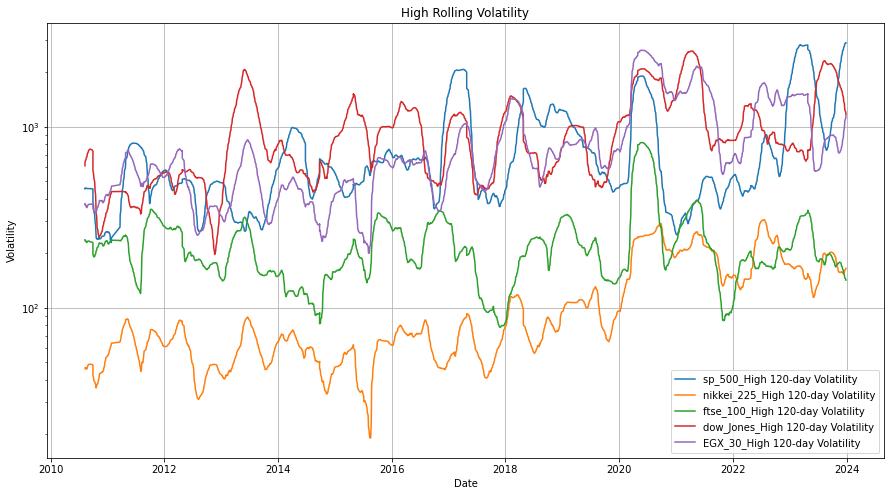

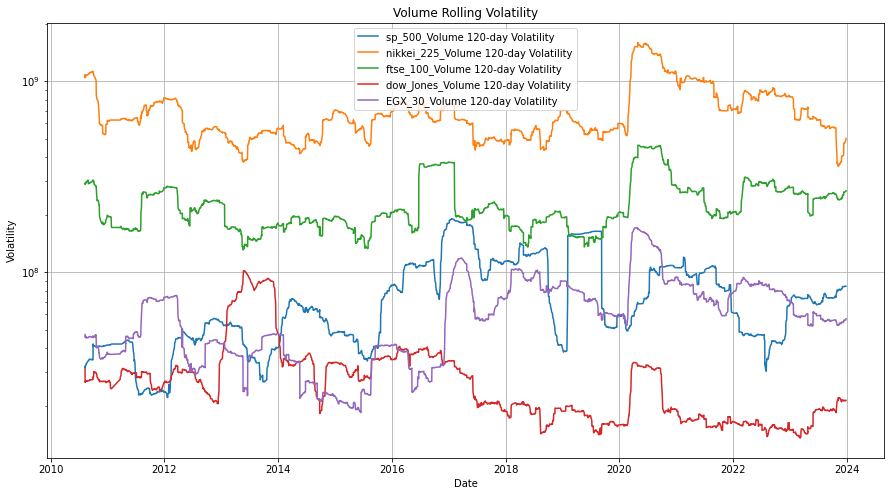

In [13]:
for i in range(5):
    plot_rolling_volatility(
        data=pdf,
        column_names=["Date"] + colNames,
        date_col="Date",
        price_cols=colNames[i::5],
        window=120,
        title= colNames[i::5][0].split("_")[-1] + " Rolling Volatility"
    )

In [30]:
from arch import arch_model

# Define the GARCH model (1, 1) for the returns
returns = data['Return'].dropna()
model = arch_model(returns, vol='Garch', p=1, q=1)

# Fit the model
garch_fit = model.fit(disp="off")
print(garch_fit.summary())

ModuleNotFoundError: No module named 'arch'